In [1]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as cp

# ase imports
import ase.io
from ase import Atoms, Atom
from ase import units
from ase.build import molecule
# for MD
from ase.md.langevin import Langevin
from ase.io.trajectory import Trajectory

In [2]:
# helper functions
def make_water(density, super_cell=[3, 3, 3]):
    """ Geenrates a supercell of water molecules with a desired density.
        Density in g/cm^3!!!"""
    h2o = molecule('H2O')
    a = np.cbrt((sum(h2o.get_masses()) * units.m ** 3 * 1E-6 ) / (density * units.mol))
    h2o.set_cell((a, a, a))
    h2o.set_pbc((True, True, True))
    #return cp(h2o.repeat(super_cell))
    return h2o.repeat(super_cell)

def rms_dict(x_ref, x_pred):
    """ Takes two datasets of the same shape and returns a dictionary containing RMS error data"""

    x_ref = np.array(x_ref)
    x_pred = np.array(x_pred)

    if np.shape(x_pred) != np.shape(x_ref):
        raise ValueError('WARNING: not matching shapes in rms')

    error_2 = (x_ref - x_pred) ** 2

    average = np.sqrt(np.average(error_2))
    std_ = np.sqrt(np.var(error_2))

    return {'rmse': average, 'std': std_}

In [3]:
# Running MD with ASE's EMT

from ase.calculators.emt import EMT
calc = EMT()

T = 150  # Kelvin

# Set up a grid of water
water = make_water(1.0, [3, 3, 3])
water.set_calculator(calc)

# We want to run MD using the Langevin algorithm
# with a time step of 1 fs, the temperature T and the friction
# coefficient to 0.002 atomic units.
dyn = Langevin(water, 1 * units.fs, T * units.kB, 0.0002)

def printenergy(a=water):  # store a reference to atoms in the definition.
    """Function to print the potential, kinetic and total energy."""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))

dyn.attach(printenergy, interval=5)

# We also want to save the positions of all atoms after every 5th time step.
traj = Trajectory('dyn_emt.traj', 'w', water)
dyn.attach(traj.write, interval=5)

# Now run the dynamics
printenergy(water)
dyn.run(600)   # CHANGE THIS IF YOU WANT LONGER/SHORTER RUN

Energy per atom: Epot = 0.885eV  Ekin = 0.000eV (T=  0K)  Etot = 0.885eV
Energy per atom: Epot = 0.885eV  Ekin = 0.000eV (T=  0K)  Etot = 0.885eV
Energy per atom: Epot = 0.820eV  Ekin = 0.053eV (T=413K)  Etot = 0.874eV
Energy per atom: Epot = 0.660eV  Ekin = 0.208eV (T=1610K)  Etot = 0.868eV
Energy per atom: Epot = 0.632eV  Ekin = 0.224eV (T=1734K)  Etot = 0.857eV
Energy per atom: Epot = 0.869eV  Ekin = 0.005eV (T= 39K)  Etot = 0.874eV
Energy per atom: Epot = 0.781eV  Ekin = 0.089eV (T=687K)  Etot = 0.869eV
Energy per atom: Epot = 0.756eV  Ekin = 0.117eV (T=907K)  Etot = 0.873eV
Energy per atom: Epot = 0.706eV  Ekin = 0.164eV (T=1269K)  Etot = 0.871eV
Energy per atom: Epot = 0.703eV  Ekin = 0.158eV (T=1223K)  Etot = 0.861eV
Energy per atom: Epot = 0.867eV  Ekin = 0.007eV (T= 51K)  Etot = 0.874eV
Energy per atom: Epot = 0.709eV  Ekin = 0.156eV (T=1209K)  Etot = 0.865eV
Energy per atom: Epot = 0.682eV  Ekin = 0.187eV (T=1444K)  Etot = 0.869eV
Energy per atom: Epot = 0.826eV  Ekin = 0.047

True

In [4]:
# wrap and save traj in .xyz --- the .traj is a non human readable database file, xyz is much better
out_traj = ase.io.read('dyn_emt.traj', ':')
for at in out_traj:
    at.wrap()
    if 'momenta' in at.arrays: del at.arrays['momenta']
ase.io.write('dyn_emt.xyz', out_traj, 'xyz')

/nix/store/dbf1zrb6616c4k0ppnxiw1xrwzc193rz-python3-3.8.5-env/lib/python3.8/site-packages/ase/io/jsonio.py:122: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a = np.array(obj)


In [5]:
isolated_H = Atoms('H', calculator=EMT(), cell=[20, 20, 20], pbc=True)
isolated_O = Atoms('O', calculator=EMT(), cell=[20, 20, 20], pbc=True)

print('e0_H:',isolated_H.get_potential_energy())
print('e0_O:',isolated_O.get_potential_energy())

# this made the e0 string be the following: e0={H:3.21:O:4.6}

e0_H: 3.21
e0_O: 4.6


In [6]:
ase.io.write('train.xyz', out_traj[0::2] + [isolated_H] + [isolated_O])
ase.io.write('validate.xyz', out_traj[1::2])

In [7]:
out_traj[0].arrays.keys()

dict_keys(['numbers', 'positions'])

In [8]:
! gap_fit energy_parameter_name=energy force_parameter_name=forces do_copy_at_file=F sparse_separate_file=T gp_file=GAP.xml at_file=train.xyz default_sigma={0.008 0.04 0 0} gap={distance_2b cutoff=4.0 covariance_type=ard_se delta=0.5 theta_uniform=1.0 sparse_method=uniform add_species=T n_sparse=10}

libAtoms::Hello World: 15/08/2020   23:34:45
libAtoms::Hello World: git version  git@github.com:libAtoms/QUIP.git,1ff93b340-dirty
libAtoms::Hello World: QUIP_ARCH    linux_x86_64_gfortran
libAtoms::Hello World: compiled on  Aug 15 2020 at 22:45:21
libAtoms::Hello World: Random Seed = 84885912
libAtoms::Hello World: global verbosity = 0

Calls to system_timer will do nothing by default


================================ Input parameters ==============================

atoms_filename = //MANDATORY//
at_file = train.xyz
gap = "distance_2b cutoff=4.0 covariance_type=ard_se delta=0.5 theta_uniform=1.0 sparse_method=uniform add_species=T n_sparse=10"
e0 = 0.0
local_property0 = 0.0
e0_offset = 0.0
e0_method = isolated
default_kernel_regularisation = //MANDATORY//
default_sigma = "0.008 0.04 0 0"
sparse_jitter = 1.0e-10
hessian_displacement = 1.0e-2
hessian_delta = 1.0e-2
baseline_param_filename = quip_params.xml
core_param_file = quip_params.xml
baseline_ip_args =
core_ip_args =
energy_parame

In [10]:
! quip E=T F=T atoms_filename=train.xyz param_filename=GAP.xml | grep AT | sed 's/AT//' > quip_train.xyz
! quip E=T F=T atoms_filename=validate.xyz param_filename=GAP.xml | grep AT | sed 's/AT//' > quip_validate.xyz

In [11]:
def energy_plot(in_file, out_file, ax, title='Plot of energy'):
    """ Plots the distribution of energy per atom on the output vs the input"""
    # read files
    in_atoms = ase.io.read(in_file, ':')
    out_atoms = ase.io.read(out_file, ':')
    # list energies
    ener_in = [at.get_potential_energy() / len(at.get_chemical_symbols()) for at in in_atoms]
    ener_out = [at.get_potential_energy() / len(at.get_chemical_symbols()) for at in out_atoms]
    # scatter plot of the data
    ax.scatter(ener_in, ener_out)
    # get the appropriate limits for the plot
    for_limits = np.array(ener_in +ener_out)
    elim = (for_limits.min() - 0.05, for_limits.max() + 0.05)
    ax.set_xlim(elim)
    ax.set_ylim(elim)
    # add line of slope 1 for refrence
    ax.plot(elim, elim, c='k')
    # set labels
    ax.set_ylabel('energy by GAP / eV')
    ax.set_xlabel('energy by EMT / eV')
    #set title
    ax.set_title(title)
    # add text about RMSE
    _rms = rms_dict(ener_in, ener_out)
    rmse_text = 'RMSE:\n' + str(np.round(_rms['rmse'], 3)) + ' +- ' + str(np.round(_rms['std'], 3)) + 'eV/atom'
    ax.text(0.9, 0.1, rmse_text, transform=ax.transAxes, fontsize='large', horizontalalignment='right',
            verticalalignment='bottom')

def force_plot(in_file, out_file, ax, symbol='HO', title='Plot of force'):
    """ Plots the distribution of firce components per atom on the output vs the input
        only plots for the given atom type(s)"""

    in_atoms = ase.io.read(in_file, ':')
    out_atoms = ase.io.read(out_file, ':')

    # extract data for only one species
    in_force, out_force = [], []
    for at_in, at_out in zip(in_atoms, out_atoms):
        # get the symbols
        sym_all = at_in.get_chemical_symbols()
        # add force for each atom
        for j, sym in enumerate(sym_all):
            if sym in symbol:
                in_force.append(at_in.get_forces()[j])
                #out_force.append(at_out.get_forces()[j]) \
                out_force.append(at_out.arrays['force'][j]) # because QUIP and ASE use different names
    # convert to np arrays, much easier to work with
    #in_force = np.array(in_force)
    #out_force = np.array(out_force)
    # scatter plot of the data
    ax.scatter(in_force, out_force)
    # get the appropriate limits for the plot
    for_limits = np.array(in_force + out_force)
    flim = (for_limits.min() - 1, for_limits.max() + 1)
    ax.set_xlim(flim)
    ax.set_ylim(flim)
    # add line of
    ax.plot(flim, flim, c='k')
    # set labels
    ax.set_ylabel('force by GAP / (eV/Å)')
    ax.set_xlabel('force by EMT / (eV/Å)')
    #set title
    ax.set_title(title)
    # add text about RMSE
    _rms = rms_dict(in_force, out_force)
    rmse_text = 'RMSE:\n' + str(np.round(_rms['rmse'], 3)) + ' +- ' + str(np.round(_rms['std'], 3)) + 'eV/Å'
    ax.text(0.9, 0.1, rmse_text, transform=ax.transAxes, fontsize='large', horizontalalignment='right',
            verticalalignment='bottom')

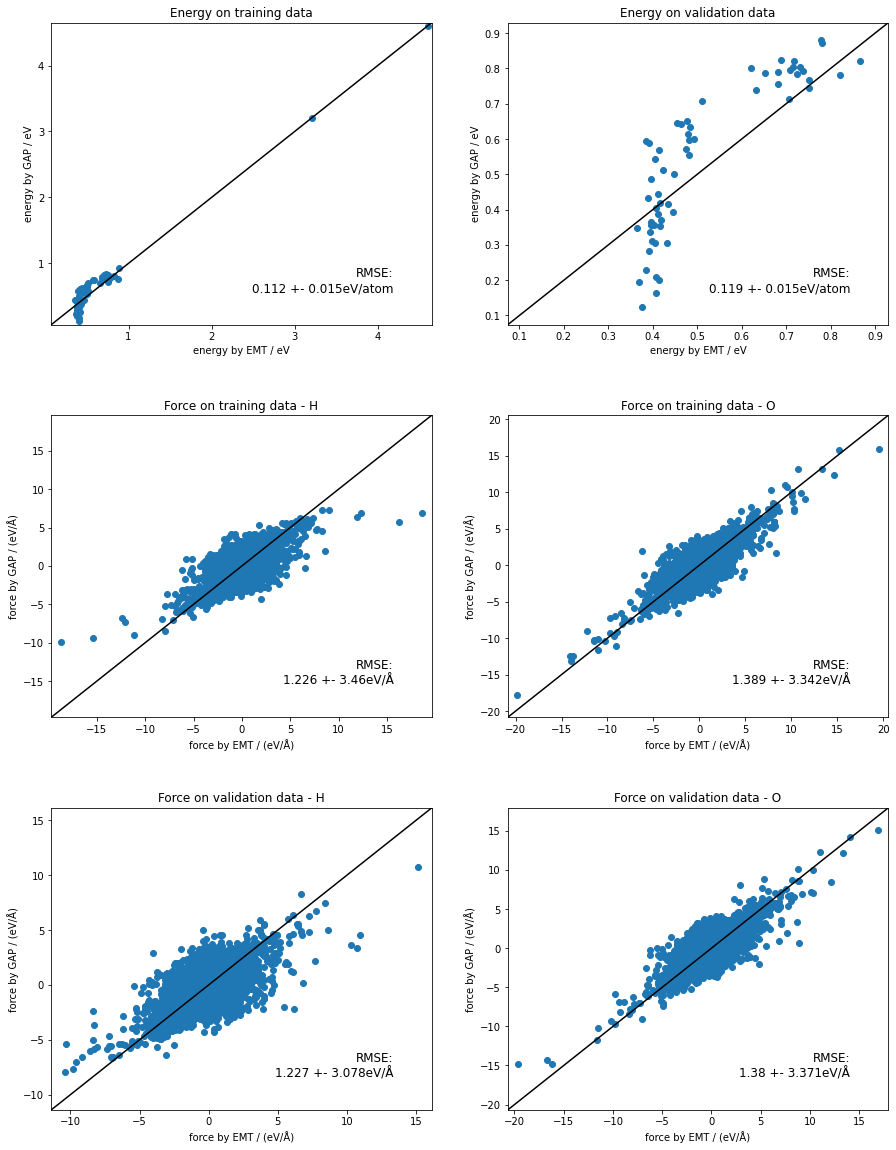

In [12]:
fig, ax_list = plt.subplots(nrows=3, ncols=2, gridspec_kw={'hspace': 0.3})
fig.set_size_inches(15, 20)
ax_list = ax_list.flat[:]

energy_plot('train.xyz', 'quip_train.xyz', ax_list[0], 'Energy on training data')
energy_plot('validate.xyz', 'quip_validate.xyz', ax_list[1], 'Energy on validation data')
force_plot('train.xyz', 'quip_train.xyz', ax_list[2], 'H', 'Force on training data - H')
force_plot('train.xyz', 'quip_train.xyz', ax_list[3], 'O', 'Force on training data - O')
force_plot('validate.xyz', 'quip_validate.xyz', ax_list[4], 'H', 'Force on validation data - H')
force_plot('validate.xyz', 'quip_validate.xyz', ax_list[5], 'O',  'Force on validation data - O')

# if you wanted to have the same limits on the force plots
#for ax in ax_list[2:]:
#    flim = (-20, 20)
#    ax.set_xlim(flim)
#    ax.set_ylim(flim)

In [13]:
! gap_fit energy_parameter_name=energy force_parameter_name=forces do_copy_at_file=F sparse_separate_file=T gp_file=GAP_3b.xml at_file=train.xyz default_sigma={0.008 0.04 0 0} gap={distance_2b cutoff=4.0 covariance_type=ard_se delta=0.5 theta_uniform=1.0 sparse_method=uniform add_species=T n_sparse=10 : angle_3b cutoff=3.5 covariance_type=ard_se delta=0.5 theta_fac=0.5 add_species=T n_sparse=30 sparse_method=uniform}


libAtoms::Hello World: 15/08/2020   23:38:08
libAtoms::Hello World: git version  git@github.com:libAtoms/QUIP.git,1ff93b340-dirty
libAtoms::Hello World: QUIP_ARCH    linux_x86_64_gfortran
libAtoms::Hello World: compiled on  Aug 15 2020 at 22:45:21
libAtoms::Hello World: Random Seed = 85088067
libAtoms::Hello World: global verbosity = 0

Calls to system_timer will do nothing by default


================================ Input parameters ==============================

atoms_filename = //MANDATORY//
at_file = train.xyz
gap = "distance_2b cutoff=4.0 covariance_type=ard_se delta=0.5 theta_uniform=1.0 sparse_method=uniform add_species=T n_sparse=10 : angle_3b cutoff=3.5 covariance_type=ard_se delta=0.5 theta_fac=0.5 add_species=T n_sparse=30 sparse_method=uniform"
e0 = 0.0
local_property0 = 0.0
e0_offset = 0.0
e0_method = isolated
default_kernel_regularisation = //MANDATORY//
default_sigma = "0.008 0.04 0 0"
sparse_jitter = 1.0e-10
hessian_displacement = 1.0e-2
hessian_delta = 1.0e-2
baseli

In [14]:
! quip E=T F=T atoms_filename=train.xyz param_filename=GAP_3b.xml | grep AT | sed 's/AT//' > quip_3b_train.xyz
! quip E=T F=T atoms_filename=validate.xyz param_filename=GAP_3b.xml | grep AT | sed 's/AT//' > quip_3b_validate.xyz

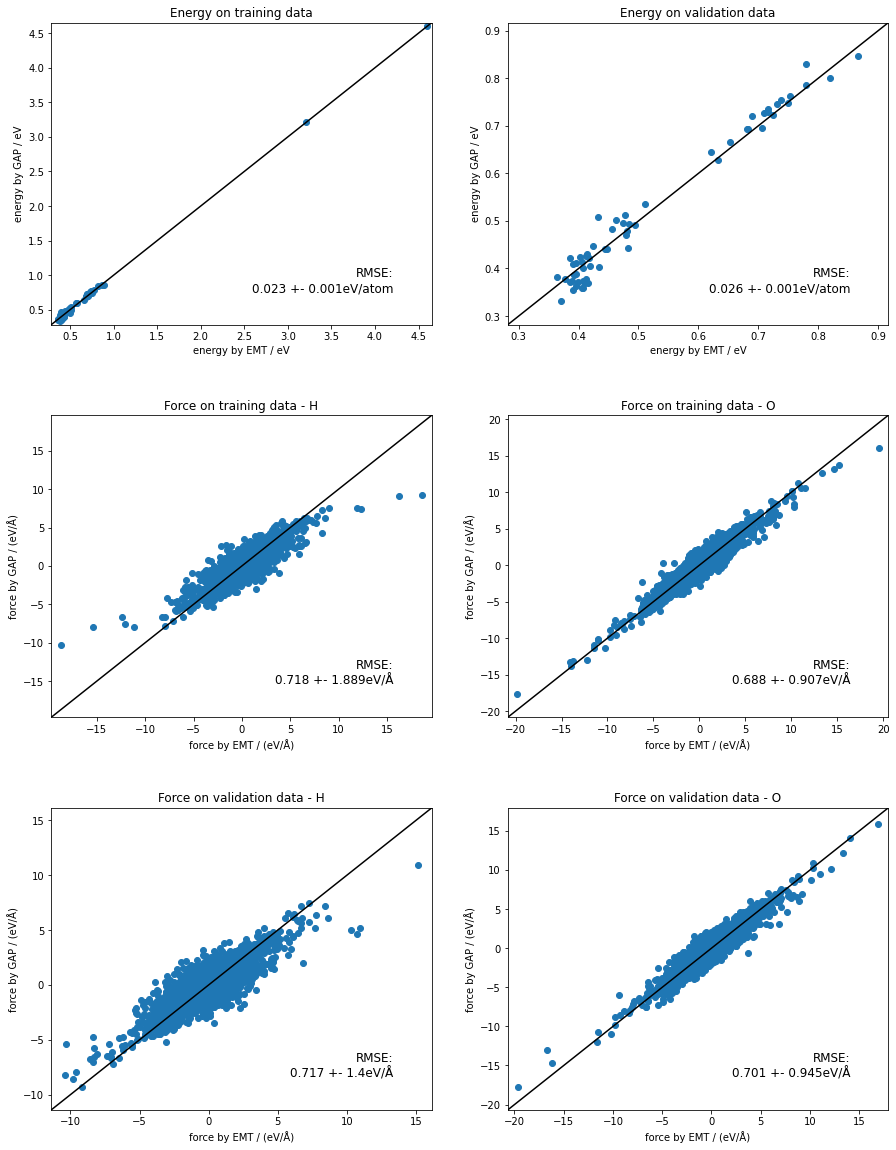

In [15]:
fig, ax_list = plt.subplots(nrows=3, ncols=2, gridspec_kw={'hspace': 0.3})
fig.set_size_inches(15, 20)
ax_list = ax_list.flat[:]

energy_plot('train.xyz', 'quip_3b_train.xyz', ax_list[0], 'Energy on training data')
energy_plot('validate.xyz', 'quip_3b_validate.xyz', ax_list[1], 'Energy on validation data')
force_plot('train.xyz', 'quip_3b_train.xyz', ax_list[2], 'H', 'Force on training data - H')
force_plot('train.xyz', 'quip_3b_train.xyz', ax_list[3], 'O', 'Force on training data - O')
force_plot('validate.xyz', 'quip_3b_validate.xyz', ax_list[4], 'H', 'Force on validation data - H')
force_plot('validate.xyz', 'quip_3b_validate.xyz', ax_list[5], 'O',  'Force on validation data - O')

# if you wanted to have the same limits on the force plots
#for ax in ax_list[2:]:
#    flim = (-20, 20)
#    ax.set_xlim(flim)
#    ax.set_ylim(flim)